Many thanks to Thiago Panini for making his content available, he provided many interesting visualizations in his notebook [Kaggle](https://www.kaggle.com/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp/data?select=viz_utils.py). 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set(style='whitegrid', palette='deep', font_scale=1.2)
pd.set_option('max_columns',40, 'precision',4)

palette = 'ch:s=-.5,r=.75'
#palette = 'mako'
#palette = 'rocket'

### Loading all datasets

There are 8 datasets. In order to manipulate them better we can create a single one. First an exploration of all the datasets.

In [2]:
data_dir = 'data/'
customer = pd.read_csv(data_dir + 'olist_customers_dataset.csv')
geolocation = pd.read_csv(data_dir + 'olist_geolocation_dataset.csv')
orders = pd.read_csv(data_dir + 'olist_orders_dataset.csv')
order_items = pd.read_csv(data_dir + 'olist_order_items_dataset.csv')
order_payments = pd.read_csv(data_dir + 'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(data_dir + 'olist_order_reviews_dataset.csv')
products = pd.read_csv(data_dir + 'olist_products_dataset.csv')
sellers = pd.read_csv(data_dir + 'olist_sellers_dataset.csv')

In [3]:
# Collections for each dataset
datasets = [customer, geolocation, orders, order_items, order_payments,
            order_reviews, products, sellers]
names = ['customer', 'geolocation', 'orders', 'order_items', 'order_payments',
         'order_reviews', 'products', 'sellers']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient(cmap='PuBuGn')

,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns
0,customer,99441,5,0,0,
1,geolocation,1000163,5,0,0,
2,orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,order_items,112650,7,0,0,
4,order_payments,103886,5,0,0,
5,order_reviews,100000,7,146532,2,"review_comment_title, review_comment_message"
6,products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers,3095,4,0,0,


### Exploring orders

First, we do a counting of the inminet feature we have (order_status). We can see how most of the products have benn delivered. Then we can do some feature engineering from the timestamps. We have the `order_purchase_timestamp` that indicates the timestamp in which a purchase was made, an analysis of this can tell us if the there is a trend in the purchases, which months had more sells, we can see in which time of the day people buy more and in which day of week.

In [4]:
def annotate_percentage(ax, data=None, total = None,title=None, size=14, fontsize=18, yy=1.02, offset=20):
    '''
    Annotates a percentage and the amounth at the top of the bar plot.
    Sets the title of the plot
    yy: height of the title
    fontsize: fontsize of the title
    size: is the size of the annotation
    '''
    if total is None:
        total = float(len(data))
    for p in ax.patches:
        percentage = '{:.1f}%\n{:.1f}'.format(100 * p.get_height()/total, p.get_height())
        x = p.get_x() + p.get_width()/2
        y = p.get_height() + offset
        ax.annotate(percentage, (x, y), ha='center', size=size)
    ax.set_title(title, fontsize=fontsize, y=yy)

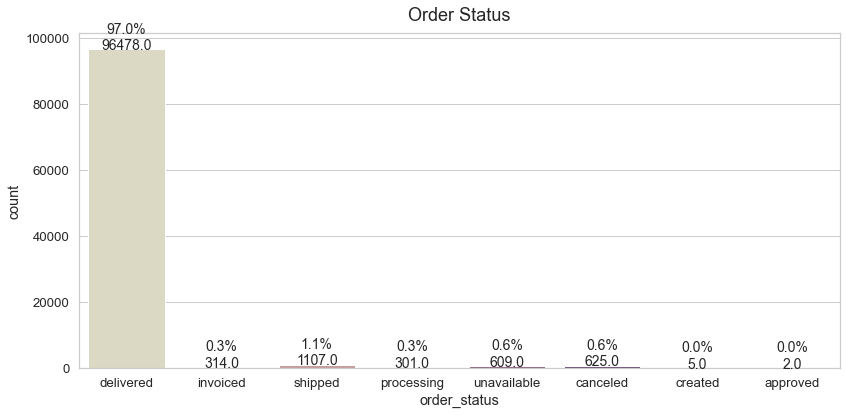

In [5]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

ax1 = sns.countplot(data=orders, x='order_status', palette=palette)
annotate_percentage(ax1, orders, title= 'Order Status')
plt.tight_layout()

Since the orders dataset is mostly date focused, we can do a feature date engineering.

In [6]:
def extract_from_date(data, timestamp_column, suffix):
    '''
    Add time fratures to dataset
    '''
    data[timestamp_column] = pd.to_datetime(data[timestamp_column])
    
    data[str(suffix + '_year')] = data[timestamp_column].dt.year
    data[str(suffix + '_month')] = data[timestamp_column].dt.month
    data[str(suffix + '_month_name')] = data[timestamp_column].dt.month_name()
    data[str(suffix + '_year_month')] = data[timestamp_column].dt.strftime('%Y%m')
    data[str(suffix + '_date')] = data[timestamp_column].dt.strftime('%Y%m%d')
    data[str(suffix + '_week')] = data[timestamp_column].dt.isocalendar().week
    data[str(suffix + '_day')] = data[timestamp_column].dt.day
    data[str(suffix + '_dayofweek')] = data[timestamp_column].dt.dayofweek
    data[str(suffix + '_day_name')] = data[timestamp_column].dt.day_name()
    data[str(suffix + '_hour')] = data[timestamp_column].dt.hour
    data[str(suffix + '_day_time')] = pd.cut(data[str(suffix + '_hour')], bins=[0, 12, 18, 23], labels=['morning', 'afternoon', 'night'])
    
    return data

In [7]:
orders_date = extract_from_date(orders, 'order_purchase_timestamp', 'order')
orders_date.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_year,order_month,order_month_name,order_year_month,order_date,order_week,order_day,order_dayofweek,order_day_name,order_hour,order_day_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017,10,October,201710,20171002,40,2,0,Monday,10,morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018,7,July,201807,20180724,30,24,1,Tuesday,20,night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018,8,August,201808,20180808,32,8,2,Wednesday,8,morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017,11,November,201711,20171118,46,18,5,Saturday,19,night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018,2,February,201802,20180213,7,13,1,Tuesday,21,night


Acording to this plot, there is a growing trend in sells. There is a fast fall at the end that is probably du to some data misshandle or some anomaly. From the 2nd graph, we can see there is some seasonality in sells, probably due to weekends, we can check that by counting the sales by week day. There was also a hughe spike aproximatly in november of 2017.

In 2016 there was no much ativity and it was only for 4 months, therefore we can start modeling from 2017, also, we will remove the last months from 2018 leaving the data up to august.

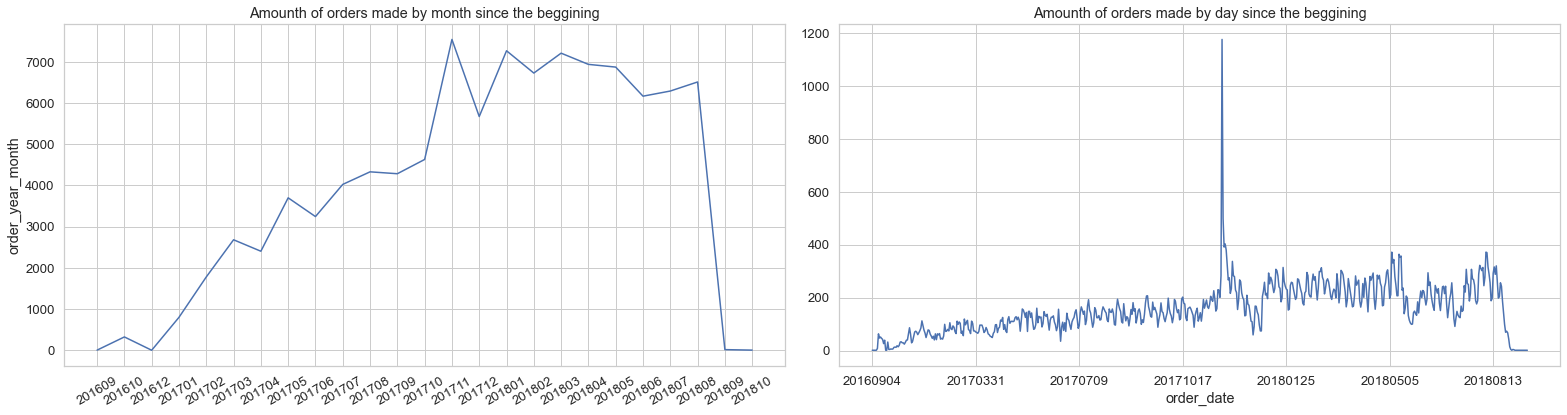

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,6))

lplot = sns.lineplot(data=orders_date, x=orders_date.order_year_month.sort_index().value_counts().index,
                   y=orders_date.order_year_month.sort_index().value_counts(), ax = ax1)
plt.setp(lplot.get_xticklabels(), rotation=30)
ax1.set_title('Amounth of orders made by month since the beggining')
orders_date.groupby('order_date').count()['order_id'].plot(ax=ax2)
ax2.set_title('Amounth of orders made by day since the beggining')
plt.tight_layout()

In [9]:
# taking all but last months
orders_date = orders_date[((orders_date['order_year_month'] <= '201807') & (orders_date['order_year'] >= 2017))]

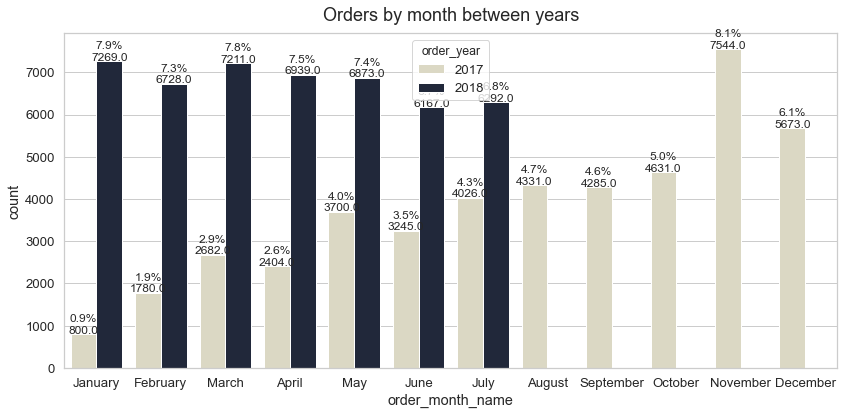

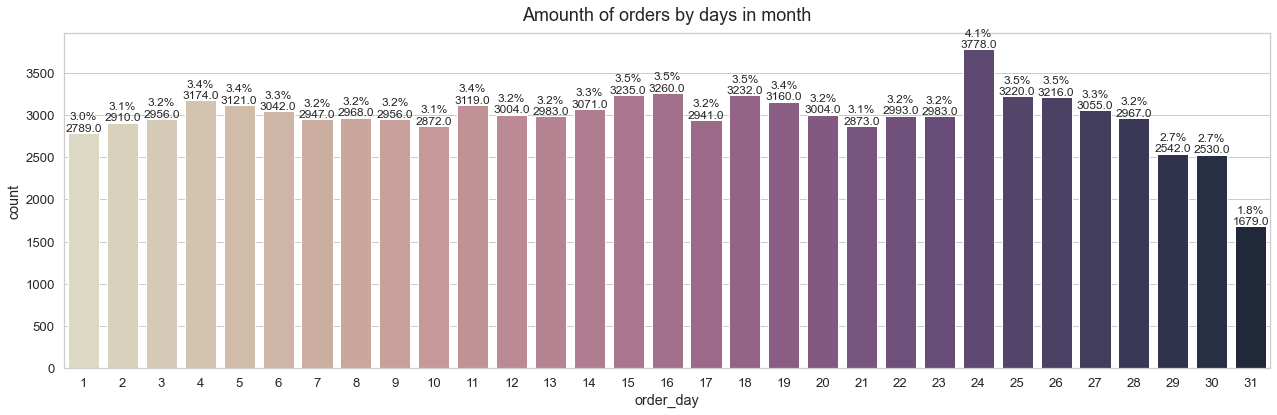

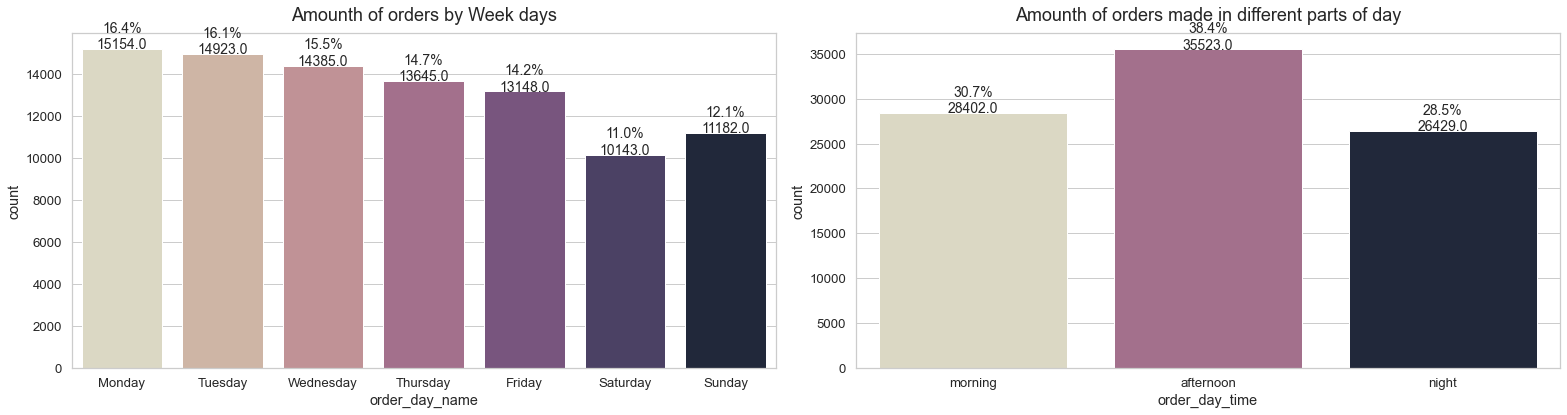

In [10]:
fig, axx = plt.subplots(1, 1, figsize=(12,6))
sns.countplot(x='order_month_name',
              #data=orders_date.set_index('order_month', drop=True).sort_index().loc[:8].sort_values(by='order_month'), #taking up to august
              data=orders_date.sort_values(by='order_month'),
              hue='order_year', ax=axx, palette=palette)
annotate_percentage(axx, orders_date, title='Orders by month between years', size=12)
plt.tight_layout()

fig, axx = plt.subplots(1, 1, figsize=(18,6))
sns.countplot(x='order_day', data=orders_date, ax=axx, palette=palette)
annotate_percentage(axx, orders_date, title='Amounth of orders by days in month', size=12)
plt.tight_layout()

fig, axx = plt.subplots(1, 2, figsize=(22,6))
sns.countplot(x='order_day_name', data=orders_date.sort_values(by='order_dayofweek'), ax=axx[0], palette=palette)
annotate_percentage(axx[0], orders_date, title='Amounth of orders by Week days')
sns.countplot(x='order_day_time', data=orders_date, ax=axx[1], palette=palette)
annotate_percentage(axx[1], orders_date, title='Amounth of orders made in different parts of day')
plt.tight_layout()

We can see that most buys are made mondays and there is a drop on weekends, also most are made in the afternoon. By the end of the month people buy much less.

### Adding the customer data

With the customer dataset we can see the states and cities of the customers. Combining it with the orders and the features we extracted from the date we can also see the hours in which customers from different regions buy more, the days of the week by regions, the progression by month or date in different states or cities.

In [11]:
# merge datasets with customer
# customer id is a foreign key of orders and the key of customers
orders_customer = orders_date.merge(customer, how='left', on='customer_id') 

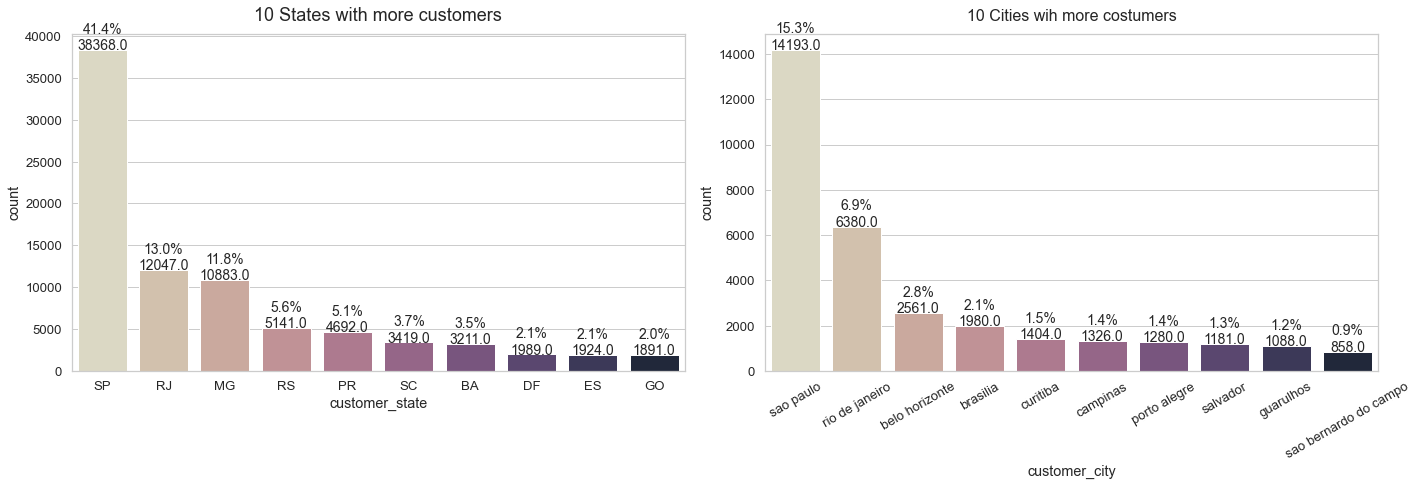

In [12]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,7))
sns.countplot(x='customer_state', data=orders_customer, ax=ax1,
              order=orders_customer.customer_state.value_counts().index[:10],
              palette=palette)
annotate_percentage(ax1, orders_customer, title='10 States with more customers')
cplot = sns.countplot(x='customer_city', data=orders_customer, ax=ax2,
                      order=orders_customer.customer_city.value_counts().index[:10],
                     palette=palette)
plt.setp(cplot.get_xticklabels(), rotation=30)
annotate_percentage(ax2, orders_customer, title='10 Cities wih more costumers',fontsize=16)
plt.tight_layout()

Most of the customers are from Sao Paulo, Rio and Matto Grosso. Sao Paulo has seen a trmendous growth in online shopping.

In [13]:
best_cities = orders_customer.groupby('customer_city').count().sort_values(by='order_id', ascending=False)[:10].index.unique()
best_states = orders_customer.groupby('customer_state').count().sort_values(by='order_id', ascending=False)[:10].index.unique()

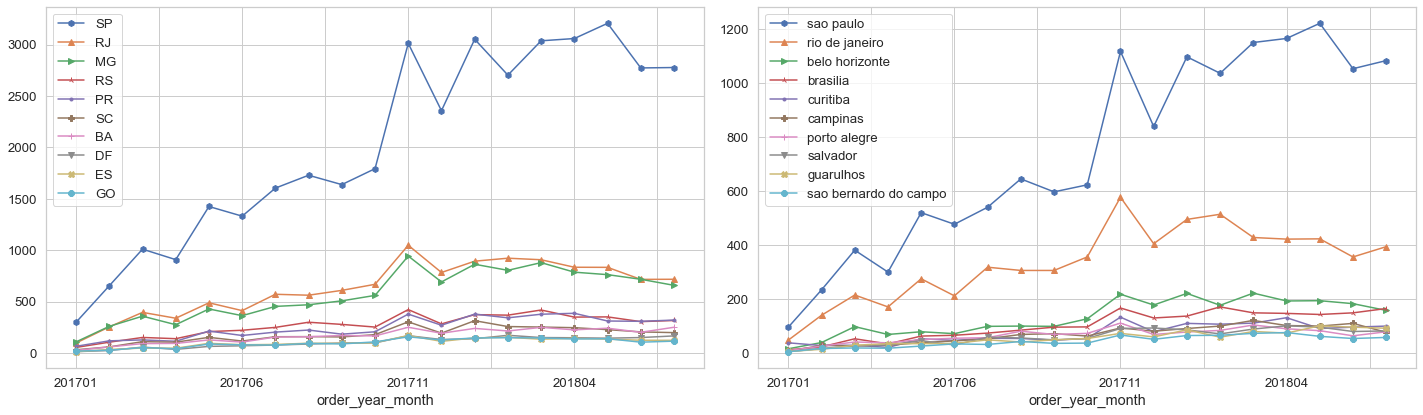

In [14]:
df = orders_customer.groupby(['customer_state', 'order_year_month']).count().sort_values(by='order_id', ascending=False)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,6))

# create valid markers from mpl.markers
valid_markers = ([item[0] for item in mpl.markers.MarkerStyle.markers.items() if
item[1] is not 'nothing' and not item[1].startswith('tick') and not item[1].startswith('caret')])
markers = np.random.choice(valid_markers, orders_customer.shape[1], replace=False)

for i, state in enumerate(best_states):
    df.loc[state].sort_index()['order_id'].plot(ax=ax1,marker=markers[i], label=state)
    ax1.legend()
    
df = orders_customer.groupby(['customer_city', 'order_year_month']).count().sort_values(by='order_id', ascending=False)    
for i, city in enumerate(best_cities):
    df.loc[city].sort_index()['order_id'].plot(ax=ax2,marker=markers[i], label=city)
plt.legend()
plt.tight_layout()

### Adding the order items dataset

The `order_items` dataset contains the price and the freight_value of the products purchased. If we combine it with the `orders_customer` we will have a price for the orders made. We can then see which states or cities buy more expensive products, the higher freights, the hours in which people buy more expensive products, we can check the amounth spent monthly.

In [15]:
# Merging orders and order_items
ord_cust_items = orders_customer.merge(order_items, how='left', on='order_id')
ord_cust_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_year,order_month,order_month_name,order_year_month,order_date,order_week,order_day,order_dayofweek,order_day_name,order_hour,order_day_time,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017,10,October,201710,20171002,40,2,0,Monday,10,morning,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018,7,July,201807,20180724,30,24,1,Tuesday,20,night,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017,11,November,201711,20171118,46,18,5,Saturday,19,night,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
3,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018,2,February,201802,20180213,7,13,1,Tuesday,21,night,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
4,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01 00:00:00,2017,7,July,201707,20170709,27,9,6,Sunday,21,night,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,1.0,060cb19345d90064d1015407193c233d,8581055ce74af1daba164fdbd55a40de,2017-07-13 22:10:13,147.90,27.36


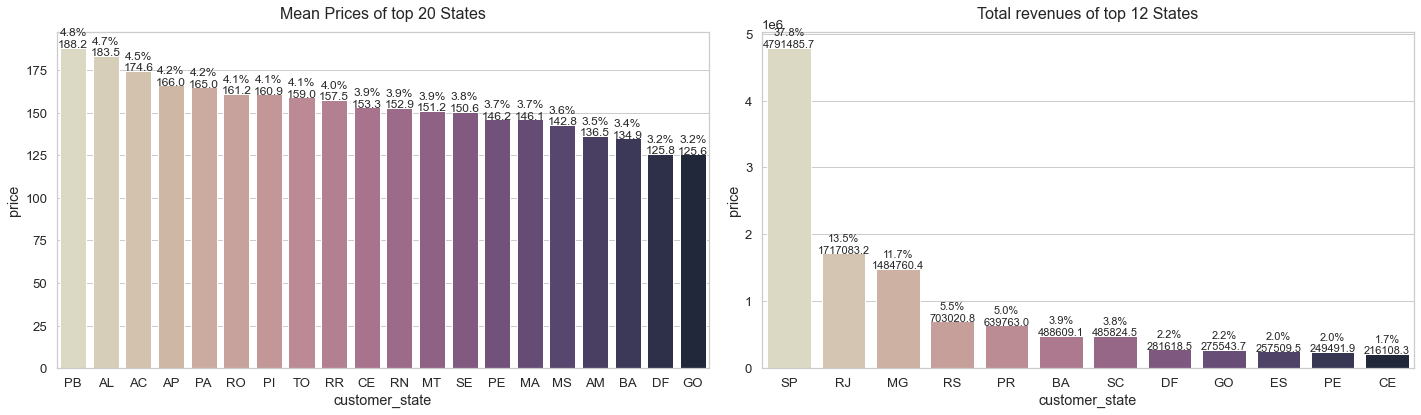

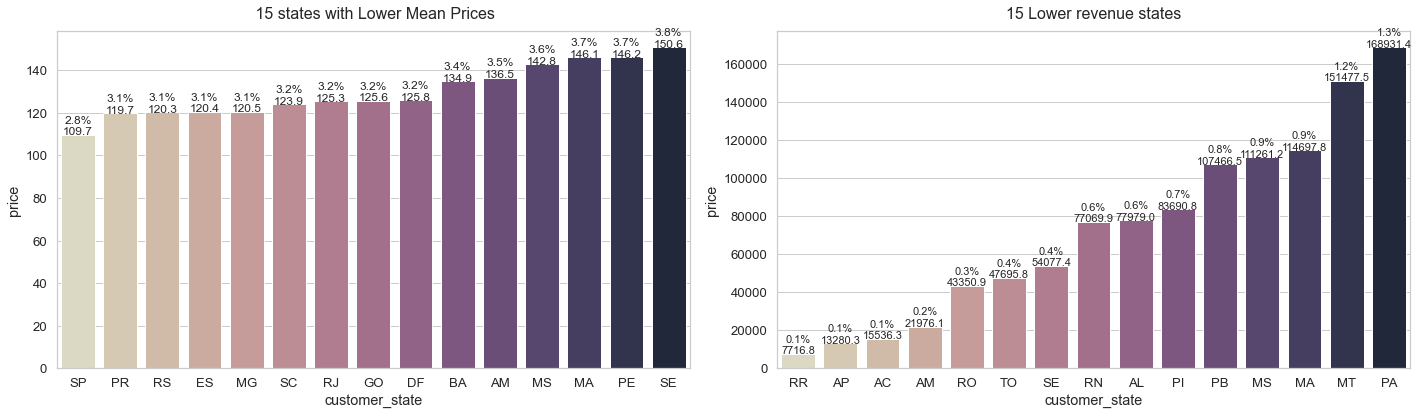

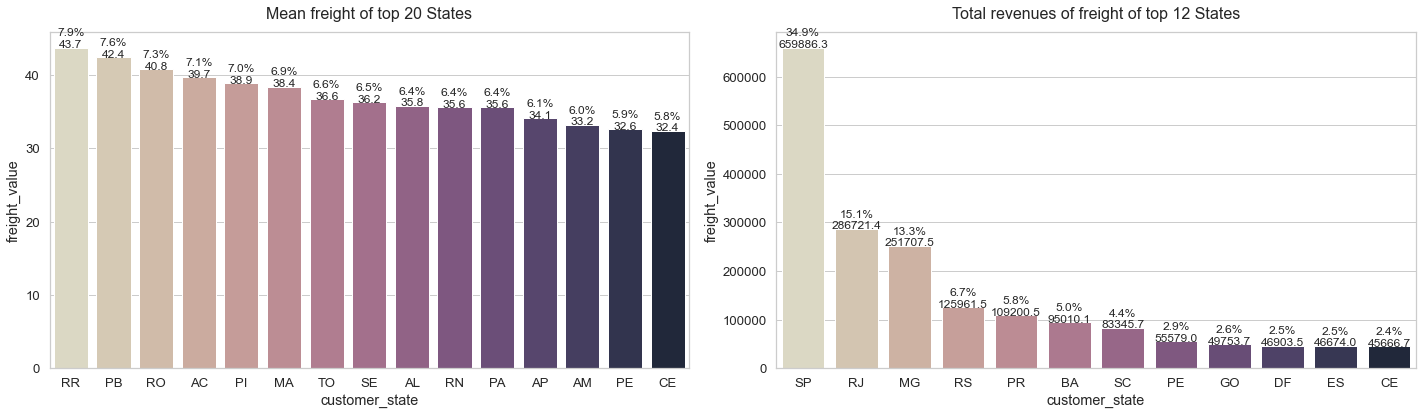

In [16]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,6))
df = ord_cust_items.groupby('customer_state').mean().sort_values(by='price', ascending=False).reset_index()
sns.barplot(data= df[:20], x ='customer_state', y = 'price', palette=palette, ax=ax1)
annotate_percentage(ax1, total=df.price.sum(), title='Mean Prices of top 20 States',fontsize=16, size=12,offset=0)

df = ord_cust_items.groupby('customer_state').sum().sort_values(by='price', ascending=False).reset_index()
sns.barplot(data= df[:12], x ='customer_state', y = 'price', palette=palette, ax=ax2)
annotate_percentage(ax2, total=df.price.sum(), title='Total revenues of top 12 States',fontsize=16, size=11,offset=0)
plt.tight_layout()

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,6))
df = ord_cust_items.groupby('customer_state').mean().sort_values(by='price', ascending=True).reset_index()
sns.barplot(data= df[:15], x ='customer_state', y = 'price', palette=palette, ax=ax1)
annotate_percentage(ax1, total=df.price.sum(), title=' 15 states with Lower Mean Prices',fontsize=16, size=12,offset=0)

df = ord_cust_items.groupby('customer_state').sum().sort_values(by='price', ascending=True).reset_index()
sns.barplot(data= df[:15], x ='customer_state', y = 'price', palette=palette, ax=ax2)
annotate_percentage(ax2, total=df.price.sum(), title='15 Lower revenue states',fontsize=16, size=11,offset=0)
plt.tight_layout()

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,6))
df = ord_cust_items.groupby('customer_state').mean().sort_values(by='freight_value', ascending=False).reset_index()[:15]
sns.barplot(data= df[:20], x ='customer_state', y = 'freight_value', palette=palette, ax=ax1)
annotate_percentage(ax1, total=df.freight_value.sum(), title='Mean freight of top 20 States',fontsize=16, size=12,offset=0)

df = ord_cust_items.groupby('customer_state').sum().sort_values(by='freight_value', ascending=False).reset_index()[:13]
sns.barplot(data= df[:12], x ='customer_state', y = 'freight_value', palette=palette, ax=ax2)
annotate_percentage(ax2, total=df.freight_value.sum(), title='Total revenues of freight of top 12 States',fontsize=16, size=12)
plt.tight_layout()

We can see how the state of Sao Paulo have a lower mean price value (109) and is at the same time the state that reports higher revenues. As we saw before, most purchases came from Sao Paulo, so it makes sense. Next we can see the history of prices of the states that generate more and the ones that generate less. There is a spike in November of 2017, probably due to Black Friday.

States that make less purchases may have a higher mean price than others because if a few customers made a high value purchase, the average will be affected. Now let's see the distribution of prices and freight by states. We will take the 5 cities with more customers and the 5 with less customers.

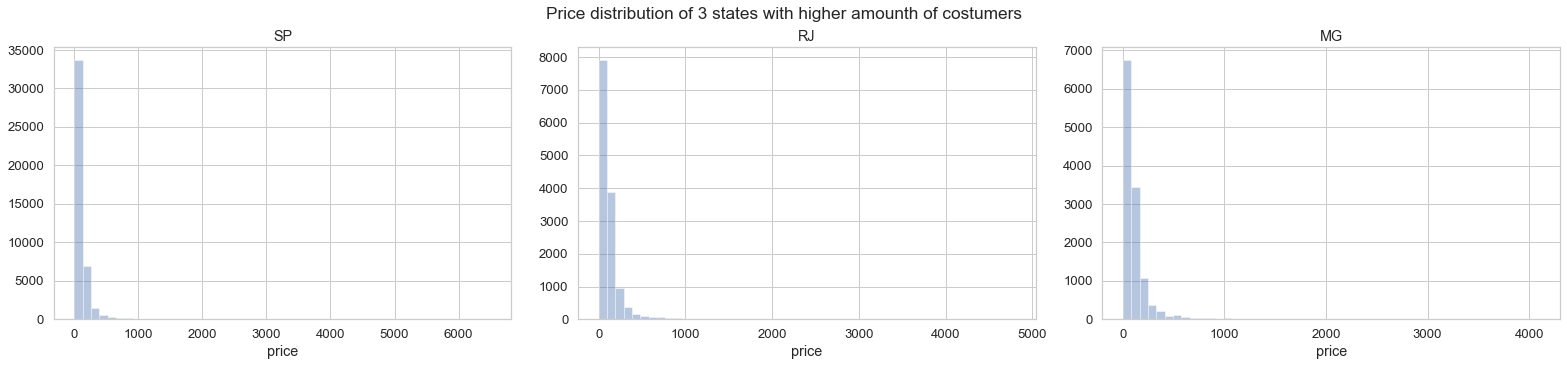

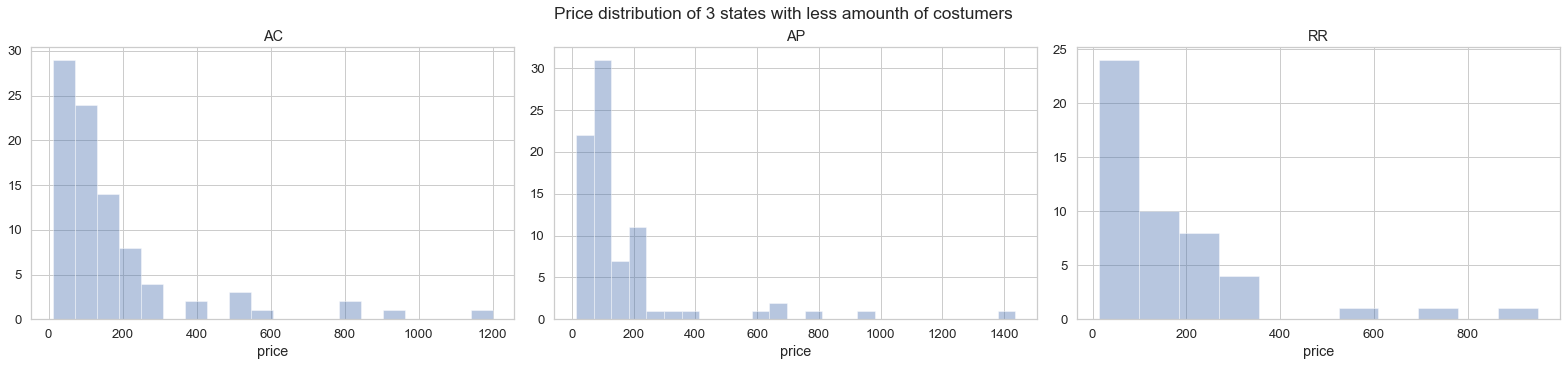

In [77]:
more_customer_states = ord_cust_items.groupby('customer_state').count().sort_values(by='order_id', ascending=False)[:5].index.unique()
less_customer_states = ord_cust_items.groupby('customer_state').count().sort_values(by='order_id', ascending=False)[-3:].index.unique()

fig, axx = plt.subplots(1, 3, figsize=(22,5))
fig.suptitle('Price distribution of 3 states with higher amounth of costumers', y=1.02)
for state, axis in zip(more_customer_states, axx.flatten()):
    sns.distplot(ord_cust_items[ord_cust_items['customer_state']==state]['price'].dropna(axis=0),
                 kde=False, ax=axis)
    axis.set_title(state)
plt.tight_layout()

fig, axx = plt.subplots(1, 3, figsize=(22,5))
fig.suptitle('Price distribution of 3 states with less amounth of costumers', y=1.02)
for state, axis in zip(less_customer_states, axx.flatten()):
    sns.distplot(ord_cust_items[ord_cust_items['customer_state']==state]['price'].dropna(axis=0),
                 kde=False, ax=axis)
    axis.set_title(state)
plt.tight_layout()

States like Sao Paulo and Rio are the ones doing more buys and buying more expensive products, we can see how the distribution is skewed to the left, this is because we have some outliers in our data, meaning, there are some high value purchases that skew the distribution.

In [17]:
df = ord_cust_items.groupby(['customer_state', 'order_year_month']).sum().sort_index()

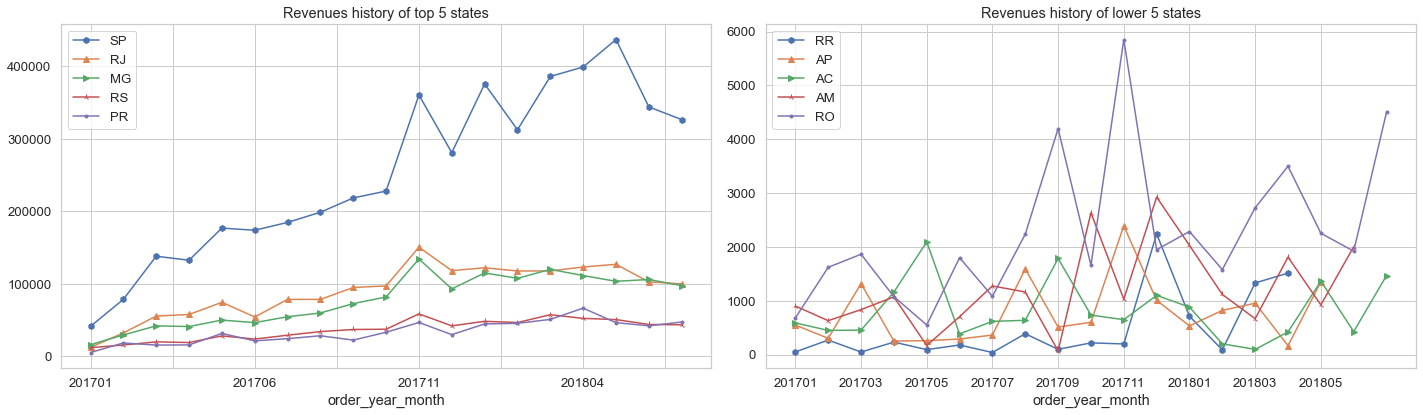

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

states = ord_cust_items.groupby('customer_state').sum().sort_values(by='price', ascending=False).index.unique()[:5].values

for i, state in enumerate(states):
    df.loc[state].sort_index()['price'].plot(ax=ax1,marker=markers[i], label=state)
    ax1.legend()
ax1.set_title('Revenues history of top 5 states')

states = ord_cust_items.groupby('customer_state').sum().sort_values(by='price', ascending=True).index.unique()[:5].values
for i, state in enumerate(states):
    df.loc[state].sort_index()['price'].plot(ax=ax2,marker=markers[i], label=state)
    ax2.legend()
ax2.set_title('Revenues history of lower 5 states')
plt.tight_layout()

### Adding the geolocation dataset
